In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
df_history = pd.read_csv(r'C:\Users\jcmar\my_files\SportsBetting\data\model_results_train_v2.csv')
df_results = pd.read_csv(r'C:\Users\jcmar\my_files\SportsBetting\data\model_results_v2.csv')

df_results['pred_winner'] = np.where(df_results['correct_pred']==1, df_results['winner'], np.abs(1-df_results['winner']))
df_results['Date'] = df_results["event_dates"].copy()
df_results.sort_values(by='Date', ascending=True).reset_index(drop=True)

df_results['prob_winner'] = df_results[['red_probs','blue_probs']].max(axis=1)
df_results['winner_odds'] = np.where(df_results['winner'] == 1, df_results['open_red'], df_results['open_blue'])
df_results['choice_fighter_bet'] = np.where(df_results['pred_winner'] == 1, df_results['open_red'], df_results['open_blue'])
df_results['Date'] = df_results["Date"].astype(str)

df_correct_pred = df_results[df_results["correct_pred"] == 1].copy() 
df_incorrect_pred = df_results[df_results["correct_pred"] == 0].copy()

pred_correct_odds = df_results[df_results["correct_pred"] == 1]['choice_fighter_bet'].value_counts().sort_index()
pred_incorrect_odds = df_results[df_results["correct_pred"] == 0]['choice_fighter_bet'].value_counts().sort_index()

df_results.head()

,Unnamed: 0,blue_probs,red_probs,pred_winner,winner,correct_pred,event_dates,open_red,open_blue,close1_red,close1_blue,close2_red,close2_blue,red_fighter,blue_fighter,Date,prob_winner,winner_odds,choice_fighter_bet
0,0,0.543981,0.456019,0,0,1,2023-08-12,163.0,-200.0,164.0,-225.0,180.0,-198.0,josh parisian,martin buday,2023-08-12,0.543981,-200.0,-200.0
1,1,0.570416,0.429584,0,0,1,2023-08-12,300.0,-400.0,260.0,-450.0,350.0,-335.0,jp buys,marcus mcghee,2023-08-12,0.570416,-400.0,-400.0
2,2,0.788572,0.211428,0,0,1,2023-08-12,163.0,-200.0,158.0,-200.0,170.0,-188.0,polyana viana,iasmin lucindo,2023-08-12,0.788572,-200.0,-200.0
3,3,0.443205,0.556795,1,1,1,2023-08-12,-225.0,175.0,-200.0,140.0,-170.0,170.0,khalil rountree jr,chris daukaus,2023-08-12,0.556795,-225.0,-225.0
4,4,0.727696,0.272304,0,1,0,2023-08-12,200.0,-250.0,175.0,-320.0,250.0,-225.0,cub swanson,hakeem dawodu,2023-08-12,0.727696,200.0,-250.0


In [3]:
def american_to_decimal(odds):
    return np.where(odds > 0, odds / 100 + 1, 100 / np.abs(odds) + 1)

df_history['dec_open_red'] = american_to_decimal(df_history['open_red'])
df_history['dec_close1_red'] = american_to_decimal(df_history['close1_red'])
df_history['dec_close2_red'] = american_to_decimal(df_history['close2_red'])

df_history['dec_open_blue'] = american_to_decimal(df_history['open_blue'])
df_history['dec_close1_blue'] = american_to_decimal(df_history['close1_blue'])
df_history['dec_close2_blue'] = american_to_decimal(df_history['close2_blue'])

df_results['dec_open_red'] = american_to_decimal(df_results['open_red'])
df_results['dec_close1_red'] = american_to_decimal(df_results['close1_red'])
df_results['dec_close2_red'] = american_to_decimal(df_results['close2_red'])

df_results['dec_open_blue'] = american_to_decimal(df_results['open_blue'])
df_results['dec_close1_blue'] = american_to_decimal(df_results['close1_blue'])
df_results['dec_close2_blue'] = american_to_decimal(df_results['close2_blue'])

In [4]:
from math import isfinite

def implied_probs_from_decimal(odds):
    """Vectorized implied probabilities from decimal odds."""
    odds = np.asarray(odds, dtype=float)
    return 1.0 / odds

def devig_normalize(probs):
    """
    Simple normalization (a.k.a. proportional scaling).
    Works for 2+ outcomes. Sum of probs becomes 1.
    """
    probs = np.asarray(probs, dtype=float)
    s = probs.sum()
    if s <= 0 or not isfinite(s):
        raise ValueError("Invalid probabilities for normalization.")
    return probs / s

def devig_power(p_imp, tol=1e-12, max_iter=200):
    """
    'Power' or 'Harville' style reweighting: find exponent alpha so that
    sum(p_i^alpha) = 1. Returns p_fair_i ∝ p_i^alpha.
    Works for 2+ outcomes. More flexible than simple normalization
    when bookmakers’ overround is not proportional.
    """
    probs = np.asarray(p_imp, dtype=float)
    if np.any(probs <= 0):
        raise ValueError("All probs must be > 0 for power devig.")
    # Binary search on alpha
    lo, hi = 0.0, 5.0  # broad range; increase hi if needed
    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        s = np.sum(probs ** mid)
        if abs(s - 1.0) < tol:
            alpha = mid
            break
        if s > 1.0:
            # Need larger alpha to shrink sum
            alpha = None
            lo = mid
        else:
            hi = mid
    alpha = mid if alpha is None else alpha
    fair = probs ** alpha
    return fair / fair.sum()

from scipy.optimize import brentq

def devig_shin(p_imp, tol=1e-8, debug=False):
    """
    Convert implied probabilities to fair probs using Shin (1993).
    Works for 2+ outcomes.
    """
    p_imp = np.asarray(p_imp, dtype=float)
    s = p_imp.sum()

    if s <= 1 + tol:
        raise ValueError(f"Implied probs sum to {s:.3f}, must be > 1 for Shin method.")

    def f(z):
        return np.sum(p_imp / (1.0 - z * (1.0 - p_imp / s))) - 1.0

    if debug:
        print(f"Testing f(z) at 0: {f(0):.6f}, at 1-tol: {f(1-tol):.6f}")

    try:
        z = brentq(f, 0, 1 - tol)
    except ValueError as e:
        raise RuntimeError(f"Root not bracketed: {e}. Check inputs {p_imp}.") from e

    fair = p_imp / (1.0 - z * (1.0 - p_imp / s))
    return fair / fair.sum()

In [5]:
def devig_two_way(dec_a, dec_b, method="normalize"):
    """
    Devig a two-outcome market.
    Returns fair probabilities (pA, pB) and fair decimal odds (oddsA, oddsB).
    """
    imp = implied_probs_from_decimal([dec_a, dec_b])
    if method == "normalize":
        pf = devig_normalize(imp)
    elif method == "power":
        pf = devig_power(imp)
    elif method == "shin":
        pf = devig_shin(imp)
    else:
        raise ValueError("method must be one of: normalize, power, shin")
    fair_odds = 1.0 / pf
    return pf[0], pf[1], fair_odds[0], fair_odds[1]


def fair_odds_curve_df(df,
                       red_col="dec_open_red",
                       blue_col="dec_open_blue",
                       method="shin",   # "normalize" | "power" | "shin"
                       n_bins=25):
    """
    For each row, devig the two-way market, compute fair probs & fair odds.
    Then bin by fair probability of 'red' and aggregate to a smooth curve.
    Returns (per_row, curve) dataframes.
    """
    rows = []
    for _, r in df.iterrows():
        da = float(r[red_col])
        db = float(r[blue_col])
        pA_imp, pB_imp = 1/da, 1/db
        pA_fair, pB_fair, oA_fair, oB_fair = devig_two_way(da, db, method=method)
        rows.append({
            "dec_open_red": da,
            "dec_open_blue": db,
            "p_imp_red_raw": pA_imp,       # <-- raw, not normalized
            "p_imp_blue_raw": pB_imp,
            "p_imp_red": pA_imp / (pA_imp + pB_imp),  # normalized implied red
            "p_imp_blue": pB_imp / (pA_imp + pB_imp),
            "p_fair_red": pA_fair,
            "p_fair_blue": pB_fair,
            "odds_fair_red": oA_fair,
            "odds_fair_blue": oB_fair
        })
    per_row = pd.DataFrame(rows)

    # Bin by fair probability of red and summarize the corresponding fair odds
    per_row["p_bin"] = pd.cut(per_row["p_fair_red"], bins=n_bins, include_lowest=True)
    curve = per_row.groupby("p_bin").agg(
        p_fair_red_mean=("p_fair_red", "mean"),
        odds_fair_red_median=("odds_fair_red", "median"),
        p_imp_red_mean=("p_imp_red", "mean"),              # for comparison
        n=("p_fair_red", "size")
    ).reset_index(drop=True)

    # Add the theoretical curve (1/p) for the averaged p_fair in each bin
    curve["odds_theoretical"] = 1.0 / curve["p_fair_red_mean"]
    return per_row, curve

In [6]:
def plot_fair_odds_curve(curve_df, title="Fair Odds Curve (Red side)"):
    plt.figure(figsize=(7,5))
    # Empirical (binned) fair odds from your market
    plt.scatter(curve_df["p_fair_red_mean"], curve_df["odds_fair_red_median"],
                label="Empirical fair price (median)", s=25)
    # Theoretical 1/p line
    plt.plot(curve_df["p_fair_red_mean"], curve_df["odds_theoretical"],
             label="Theoretical fair odds = 1/p", linewidth=2)
    plt.xlabel("Fair probability (Red)")
    plt.ylabel("Decimal odds")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.show()

C:\Users\jcmar\AppData\Local\Temp\ipykernel_46988\1107883475.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  curve = per_row.groupby("p_bin").agg(


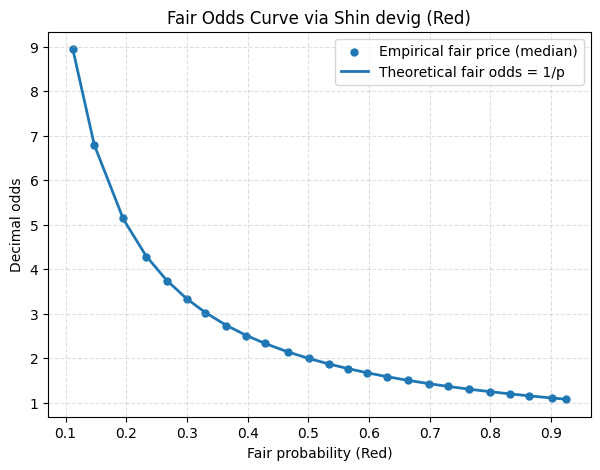

In [7]:
# Example: df has columns 'dec_red' and 'dec_blue' (decimal odds per fight)
per_row, curve = fair_odds_curve_df(df_history, method="power", n_bins=25)
plot_fair_odds_curve(curve, title="Fair Odds Curve via Shin devig (Red)")

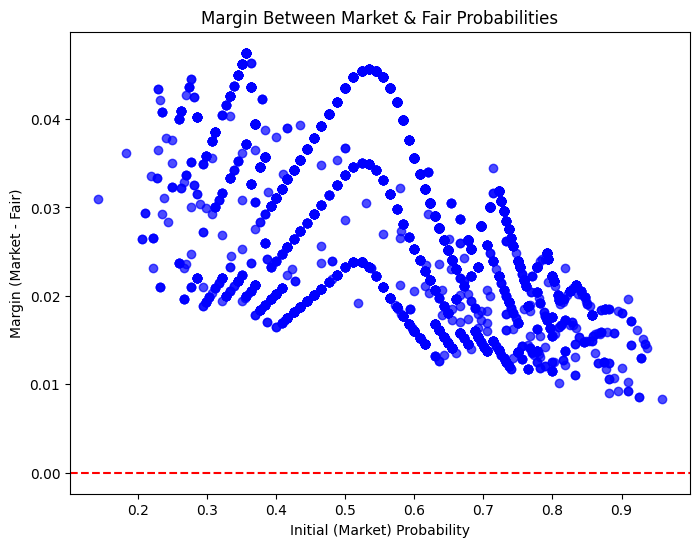

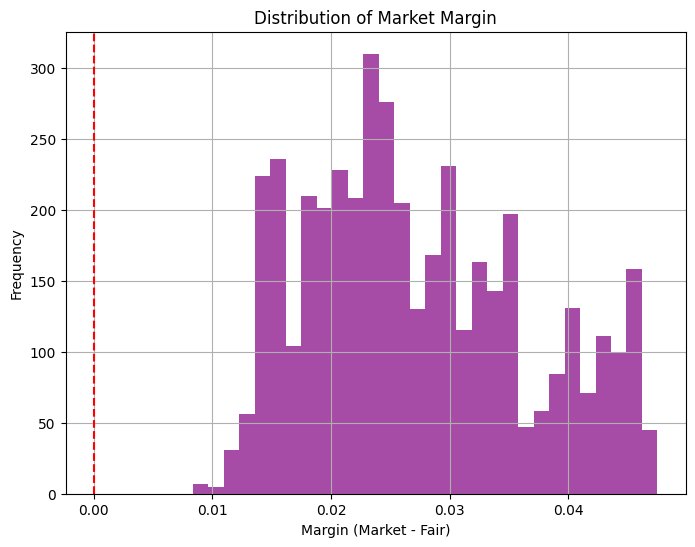

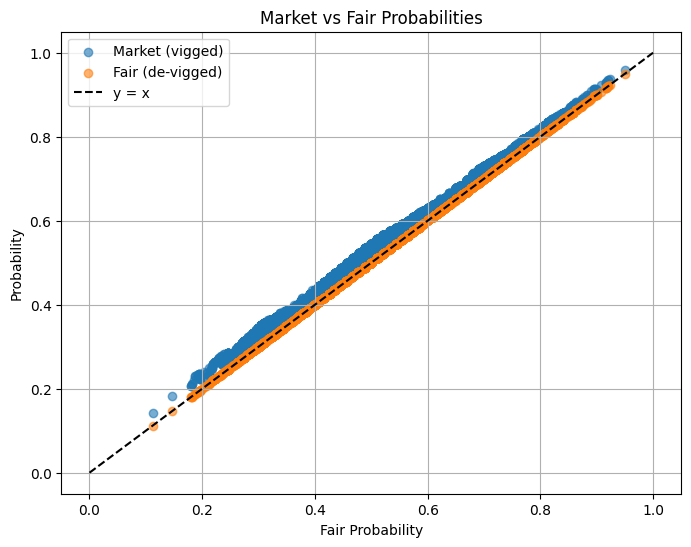

In [8]:
def plot_prob_margin(df, fair_col, initial_col, title="Margin Between Market & Fair Probabilities"):
    """
    Plot initial (vigged) probabilities vs their margin over fair (de-vigged).
    """
    df = df.copy()
    df["margin"] = df[initial_col] - df[fair_col]

    plt.figure(figsize=(8,6))
    plt.scatter(df[initial_col], df["margin"], alpha=0.7, c="blue")
    plt.axhline(0, color="red", linestyle="--")

    plt.xlabel("Initial (Market) Probability")
    plt.ylabel("Margin (Market - Fair)")
    plt.title(title)
    # plt.grid(True)
    plt.show()

def plot_fair_vs_market_probs(df, fair_col, initial_col, title="Market vs Fair Probabilities"):
    plt.figure(figsize=(8,6))
    plt.scatter(df[fair_col], df[initial_col], alpha=0.6, label="Market (vigged)")
    plt.scatter(df[fair_col], df[fair_col], alpha=0.6, label="Fair (de-vigged)")
    plt.plot([0,1],[0,1], "k--", label="y = x")

    plt.xlabel("Fair Probability")
    plt.ylabel("Probability")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_margin_hist(df, fair_col, initial_col, title="Distribution of Market Margin"):
    margin = df[initial_col] - df[fair_col]
    plt.figure(figsize=(8,6))
    plt.hist(margin, bins=30, alpha=0.7, color="purple")
    plt.axvline(0, color="red", linestyle="--")

    plt.xlabel("Margin (Market - Fair)")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_prob_margin(per_row, 'p_fair_red', 'p_imp_red_raw')
plot_margin_hist(per_row, 'p_fair_red', 'p_imp_red_raw')
plot_fair_vs_market_probs(per_row, 'p_fair_red', 'p_imp_red_raw')

In [9]:
per_row[['p_fair_red', 'p_fair_blue','p_imp_red_raw', 'p_imp_blue_raw', 'dec_open_red', 'dec_open_blue', 'odds_fair_red', 'odds_fair_blue']].head(10)

,p_fair_red,p_fair_blue,p_imp_red_raw,p_imp_blue_raw,dec_open_red,dec_open_blue,odds_fair_red,odds_fair_blue
0,0.689898,0.310102,0.705882,0.333333,1.416667,3.000000,1.449489,3.224750
1,0.616434,0.383566,0.629630,0.400000,1.588235,2.500000,1.622235,2.607111
2,0.500000,0.500000,0.545455,0.545455,1.833333,1.833333,2.000000,2.000000
3,0.259196,0.740804,0.294118,0.761905,3.400000,1.312500,3.858080,1.349885
4,0.726002,0.273998,0.750000,0.312500,1.333333,3.200000,1.377406,3.649665
5,0.680082,0.319918,0.705882,0.357143,1.416667,2.800000,1.470411,3.125799
6,0.477574,0.522426,0.512195,0.555556,1.952381,1.800000,2.093916,1.914147
7,0.608727,0.391273,0.636364,0.425532,1.571429,2.350000,1.642773,2.555758
8,0.680082,0.319918,0.705882,0.357143,1.416667,2.800000,1.470411,3.125799
9,0.242608,0.757392,0.277778,0.777778,3.600000,1.285714,4.121875,1.320320


In [10]:
curve[['p_fair_red_mean', 'p_imp_red_mean', 'odds_theoretical']]

,p_fair_red_mean,p_imp_red_mean,odds_theoretical
0,0.111846,0.136986,8.940827
1,0.147305,0.174432,6.788655
2,0.195326,0.217085,5.119637
3,0.232588,0.255044,4.299450
4,0.266308,0.282567,3.755054
5,0.299497,0.316558,3.338937
6,0.330320,0.344525,3.027369
7,0.364011,0.373386,2.747168
8,0.396502,0.404134,2.522053
9,0.428985,0.434571,2.331083


In [35]:
curve.columns

Index(['p_fair_red_mean', 'odds_fair_red_median', 'p_imp_red_mean', 'n',
       'odds_theoretical'],
      dtype='object')